In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time

from numpy.core.umath import pi
from numpy.ma import sin

num_steps = 100
scale = 100
damping= 0.25
initial_P = 250

In [2]:
def wave_propogation(num_steps,scale=100,damping=0.25,initial_P=250):
    omega = 3 / (2 * pi)
    
    size_x = 2 * scale + 1
    size_y = 2 * scale + 1 
    vertPos = int(scale)
    horizPos = int(scale)
    max_pressure = initial_P / 2
    min_presure = -initial_P / 2

    # V velocity
    # P presure
    # Initialization
    P = [[0.0 for x in range(size_x)] for y in range(size_y)]
    V = [[[0.0, 0.0, 0.0, 0.0] for x in range(size_x)] for y in range(size_y)]
    P[vertPos][horizPos] = initial_P
    start = time.time()
    for step in range(num_steps):
        P[vertPos][horizPos] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * sum(V[i][j])
    
    end = time.time()
    print(f'{end-start} S ===> {num_steps/(end-start)} Hz')
    return P

5.673587799072266 S ===> 17.625531417060614 Hz


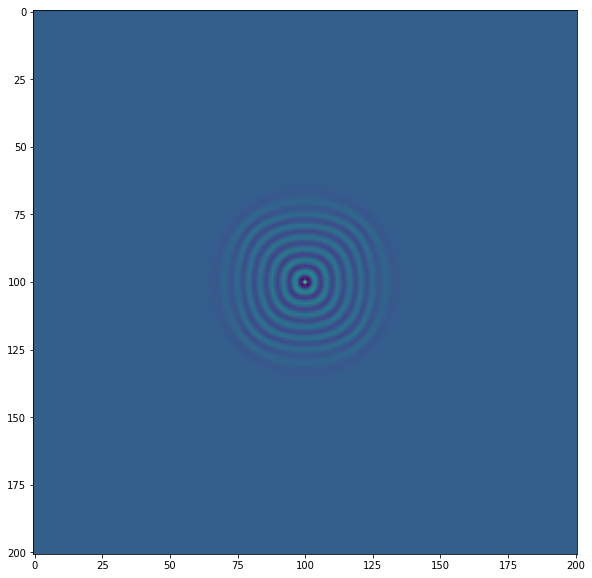

In [3]:
plt.figure(figsize=(10,10))
pressure = wave_propogation(num_steps,scale=scale,damping=damping,initial_P=initial_P)
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

In [4]:
%%cython -a
from numpy.core.umath import pi
from numpy.ma import sin
import time
cimport cython

def wave_propogation_cy(num_steps,scale=100,damping=0.25,initial_P=250):
    start = time.time()
    omega = 3 / (2 * pi)
    
    size_x = 2 * scale + 1
    size_y = 2 * scale + 1 
    vertPos = int(scale)
    horizPos = int(scale)
    max_pressure = initial_P / 2
    min_presure = -initial_P / 2

    # V velocity
    # P presure
    # Initialization
    P = [[0.0 for x in range(size_x)] for y in range(size_y)]
    V = [[[0.0, 0.0, 0.0, 0.0] for x in range(size_x)] for y in range(size_y)]
    P[vertPos][horizPos] = initial_P
    for step in range(num_steps):
        P[vertPos][horizPos] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * sum(V[i][j])
    end = time.time()
    print(f'{end-start} S ===> {num_steps/(end-start)} Hz')
    return P

3.156614303588867 S ===> 31.67951177510234 Hz


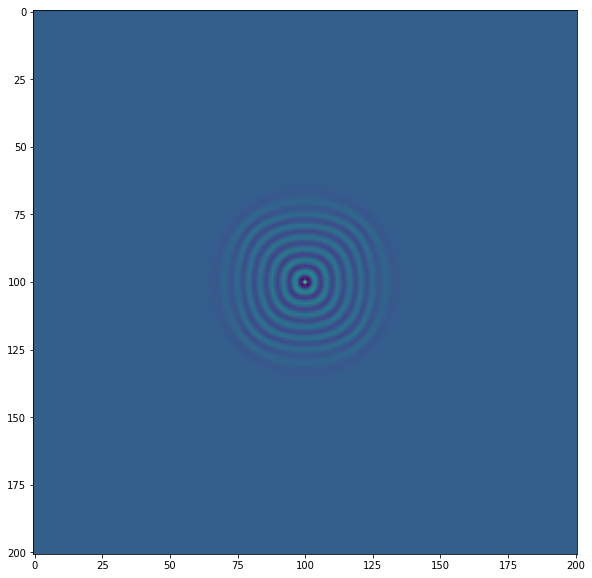

In [5]:
plt.figure(figsize=(10,10))
pressure = wave_propogation_cy(num_steps,scale=scale,damping=damping,initial_P=initial_P)
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

In [6]:
%%cython -a
import time
from libc.math cimport M_PI as pi
from libc.math cimport sin as sin
cimport cython
from cython.view cimport array as cvarray

@cython.boundscheck(False)
@cython.cdivision(False)
@cython.wraparound(False)
def wave_propogation_cy_fast(int num_steps, int scale=100,float damping=0.25,float initial_P=250.0):
    start = time.time()
    cdef float omega = 3.0 / (2.0 * pi)
    
    cdef int size_x = 2 * scale + 1
    cdef int size_y = 2 * scale + 1 
    cdef int vertPos = scale
    cdef int horizPos = scale
    cdef float max_pressure = initial_P / 2.0
    cdef float min_presure = -initial_P / 2.0
    
    cdef int i = 0
    cdef int j = 0
    cdef int step = 0

    # V velocity
    # P presure
    # Initialization
    
    cdef float [:,:] P = cvarray(shape=(size_x, size_y), itemsize=sizeof(float), format="f")
    P[:,:] = 0.0
    cdef float [:,:,:] V = cvarray(shape=(size_x, size_y,4), itemsize=sizeof(float), format="f")
    V[:,:,:] = 0.0
    
    P[vertPos][horizPos] = initial_P
    
    for step in range(num_steps):
        P[vertPos][horizPos] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * (V[i][j][0]+V[i][j][1]+V[i][j][2]+V[i][j][3])
    end = time.time()
    print(f'{end-start} S ===> {num_steps/(end-start)} Hz')
    return P

0.023900508880615234 S ===> 4184.011332122977 Hz


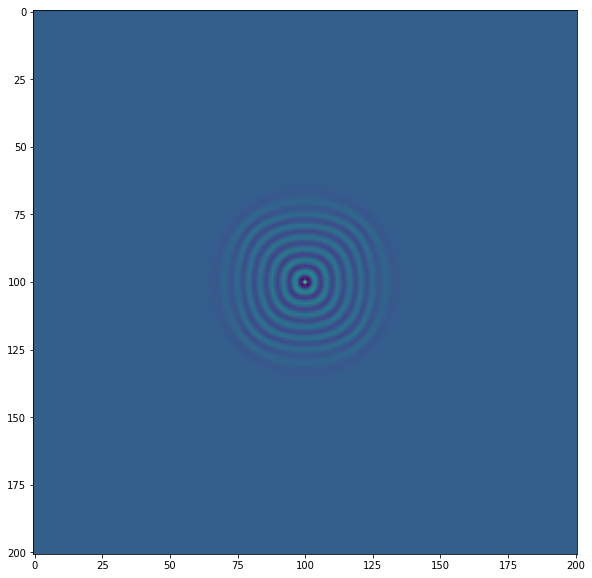

In [7]:
plt.figure(figsize=(10,10))
pressure = wave_propogation_cy_fast(num_steps,scale=scale,damping=damping,initial_P=initial_P)
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

In [8]:
import cpp.build.wave_propogation as wave_propogation

0.06568598747253418 S ===> 1522.3947122940615 Hz


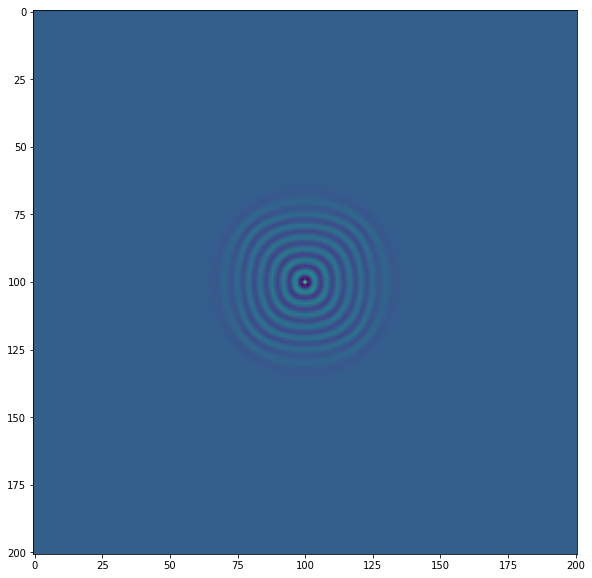

In [9]:
start = time.time()
pressure = wave_propogation.wave_propogation_cpp(num_steps, scale, damping, initial_P)
end = time.time()

print(f'{end-start} S ===> {num_steps/(end-start)} Hz')
plt.figure(figsize=(10,10))
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

1.411388874053955 S ===> 7085.2195194630085 Hz


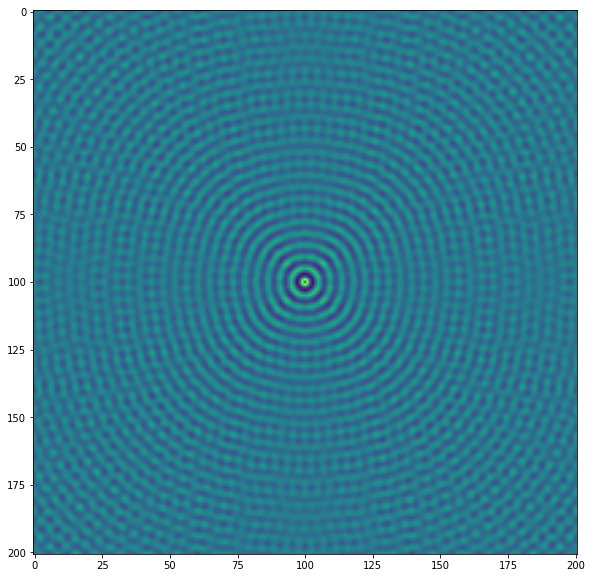

In [10]:
num_steps = 100
start = time.time()
pressure = wave_propogation.wave_propogation_cpp(num_steps, scale, damping, initial_P)
end = time.time()

print(f'{end-start} S ===> {num_steps/(end-start)} Hz')
plt.figure(figsize=(10,10))
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

0.3248558044433594 S ===> 30782.888479197736 Hz


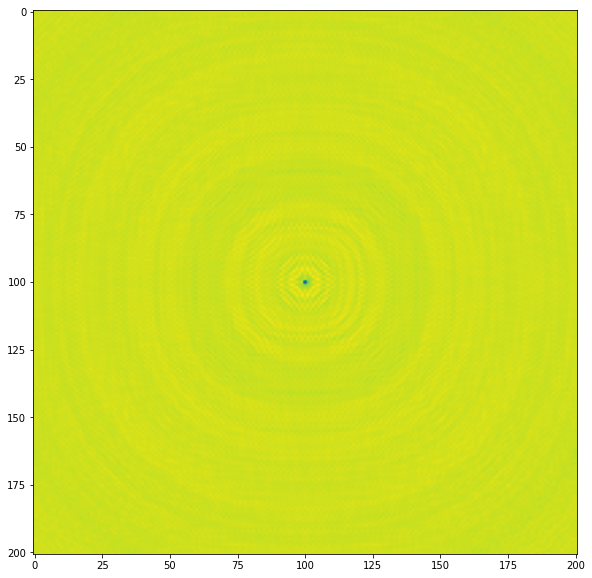

In [11]:
num_steps = 100
start = time.time()
pressure = wave_propogation.wave_propogation_cpp_omp(num_steps, scale, damping, initial_P)
end = time.time()

print(f'{end-start} S ===> {num_steps/(end-start)} Hz')
plt.figure(figsize=(10,10))
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')